The following will take you step-by-step of how to create a map in gif form. What's being depicted here is every domestic flight flying into Boston for the month of October in 2022. The red lines are flights arriving more than 30 min late while the cyan are the lucky ones who managed to make it on time. 

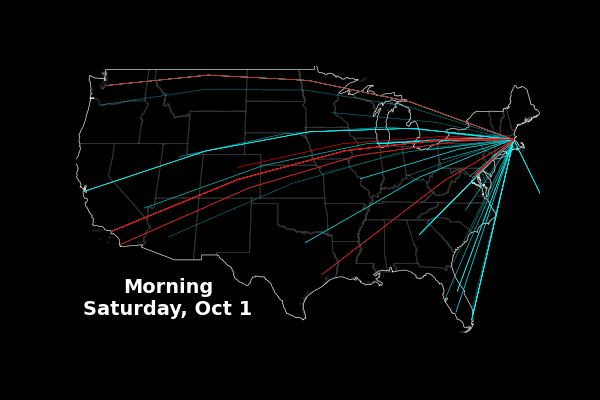

In [14]:
gif_output = Image.open('delayedflights.gif')
gif_output

In [1]:
import pandas as pd
import geopandas as gpd

import zipfile

import os
import glob
import gc

from shapely import wkt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


C:\Users\Cullen\anaconda3\envs\geo_env\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


**Read in your data files**
- airport info curtesy of DoT: https://www.transtats.bts.gov/ontime/

In [2]:
fileloc_airports = 'data/T_MASTER_CORD_20230227_103143.zip'
airports = pd.read_csv(fileloc_airports, compression='zip')

# generic admin boundary files
fileloc_outline = 'data/lower48.shp'
lower48 = gpd.read_file(fileloc_outline)

fileloc_states = 'data/states.shp'
states = gpd.read_file(fileloc_states)

- Also from DoT, these csvs were downloaded in multiple installments, one for each domestic carrier that flies into Logan

In [3]:
DOWNLOADPATH = 'e:/downloads'
files = glob.glob(os.path.join(DOWNLOADPATH,'Detailed_Statistics*'))

# Create a list to store each incoming dataframe
dfs = list()
for f in files:
#     they aere all named in a similar format "Detailed_Statistics(number).csv"
#     the csvs had a header so skip those rows when importing
#     add a dfin column and populate that with the download number between parenthesis, will be used as a key later on
    dfin = pd.read_csv(f, skiprows=7)
    if '(' in f:
        dfin['dlnum'] = int(f[-6])
    else:
#         the initial download doesn't have the (number) so we catch it here
        dfin['dlnum'] = 0
    dfs.append(dfin)

# turn the list of dataframes into a single dataframe one on top of the other using concatenate
flights = pd.concat(dfs, ignore_index=True)

# remove any rows with no data / NaN values
flights.dropna(inplace=True)

**Manipulate the dataframes so that you have everything in one tidy spot**


In [4]:
# here's where we use the download order key from earlier. since each download was associated
# with a single carrier we use that key ('codes') to join the carrier name
codes = [0,1,2,3,4,5,6,7,8,9]
cars = ['american','southwest','alaska','allegiant','delta','frontier','hawaiian','jet blue','spirit','united']

airlinecodes = pd.DataFrame(zip(codes,cars)
                            ,columns=['code','airline'])

In [5]:
# join the flight dataframe with the airline codes/carrier name using a left join to retain all the flights
# while only joining the pertinent carrier. 
flights = flights.merge(
                        airlinecodes[['code','airline']], 
                        left_on='dlnum', 
                        right_on='code', 
                        how='left'
                        ).drop('code',1)

In [6]:
# grab the coordinates for the origin airports for each flight. drop the pivot field so there isn't a duplicate
flights = flights.merge(
                        airports[['AIRPORT','LATITUDE','LONGITUDE']],
                        left_on='Origin Airport',
                        right_on='AIRPORT',
                        how='left'
                        ).drop('AIRPORT',1)


In [7]:
# rename the columns
old = ['LATITUDE','LONGITUDE']
new = ['origin_lat','origin_lon']

# you can rename with a dictionary so use zip again here 
flights.rename(columns=dict(zip(old,new)), inplace=True)

In [8]:
flights['dst_lat'] = airports[airports['AIRPORT']=='BOS'].iloc[0]['LATITUDE']
flights['dst_lon'] = airports[airports['AIRPORT']=='BOS'].iloc[0]['LONGITUDE']

In [9]:
# in order to use multiple columns as entities to create input for our paths column utilize apply a lambda function
# it'll "apply" the function to each row
# the f-string here will create the wkt string we'll use as our geometery
flights['paths'] = flights.apply(lambda r: f'LINESTRING({r.origin_lon} {r.origin_lat},{r.dst_lon} {r.dst_lat})', 1)

In [10]:
flights['arrivaldate'] = pd.to_datetime(flights['Date (MM/DD/YYYY)'])
flights['arrivalhour'] = flights.apply(lambda h:int(h['Actual Arrival Time'].split(':')[0]), axis=1)


In [11]:
# turn the dataframe into a geodataframe using the f-string from earlier as the wkt geometry
flightpaths = gpd.GeoDataFrame(flights, geometry=gpd.GeoSeries.from_wkt(flights['paths']))

**Create the individual maps (frames)**

finished: Morning Saturday, Oct 1)
finished: Afternoon Saturday, Oct 1)
finished: Morning Sunday, Oct 2)
finished: Afternoon Sunday, Oct 2)
finished: Morning Monday, Oct 3)
finished: Afternoon Monday, Oct 3)
finished: Morning Tuesday, Oct 4)
finished: Afternoon Tuesday, Oct 4)
finished: Morning Wednesday, Oct 5)
finished: Afternoon Wednesday, Oct 5)
finished: Morning Thursday, Oct 6)
finished: Afternoon Thursday, Oct 6)


KeyboardInterrupt: 

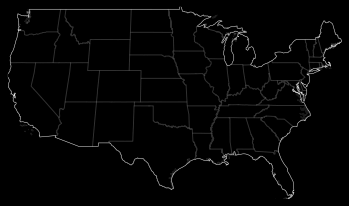

In [12]:
# storing the proj4 string to match up crs with the ccrs package
albers = '+proj=aea +lat_0=0 +lon_0=0 +lat_1=20 +lat_2=50 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs'
inter = '+proj=igh +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs'

thecrs=inter
ctr=0

# here's where we style they frames or each individual map
for d in range(1,32):
    ctr+=1
    numdate = d
#     take a pass at the AM time slot since we're using a range as the 'date'
    fig = plt.figure(facecolor='black')
    ax = plt.axes(projection=ccrs.InterruptedGoodeHomolosine())

    # fig.set_size_inches(num,num)
    ax.patch.set_facecolor('black')

#     grab the bounding box to set up the frame dimensions and set the axes values
    minx, miny, maxx, maxy = lower48.to_crs(thecrs).geometry.total_bounds
    ax.set_xlim(minx - .1, maxx + .1) # added/substracted value is to give some margin around total bounds
    ax.set_ylim(miny - .1, maxy + .1)
    
    filteredflights = flightpaths[(flightpaths.arrivaldate.dt.day==numdate)&(flightpaths.arrivalhour<12)]
    
#     develop the map layers
    map = lower48.to_crs(thecrs).plot(ax=ax, color='none', edgecolor='white', linewidth=0.4)
#     filtering out AK and HI for layout purposes
    map = states[~states.NAME.isin(['Alaska','Hawaii'])].to_crs(thecrs).plot(ax=ax, color='none', edgecolor='white', alpha=0.1)
    map = filteredflights[(flightpaths['Arrival Delay (Minutes)']<=30)].plot(ax=ax, transform=ccrs.Geodetic(), color='cyan', linewidth=0.4, alpha=0.3, zorder=5)
    map = filteredflights[(flightpaths['Arrival Delay (Minutes)']> 30)].plot(ax=ax, transform=ccrs.Geodetic(), color='red', linewidth=0.4, alpha=.7, zorder=5000)


#     plt.setp(ax.spines.values(), color='black')
#     plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
    ax.set_title(f'Morning\n{filteredflights[filteredflights.arrivaldate.dt.day==numdate]["arrivaldate"].dt.day_name().iloc[0]}, Oct {numdate}', y=1, pad=-180, x=.2, color='white', fontsize=14, fontweight='bold')

    basepath = 'need to fill this back in with the basepath to the project folder'
    fileout=os.path.join(basepath+f'boston_oct2022_delay30min_{ctr}.png')
    
#     export those png files
    mapfig = map.get_figure()
    mapfig.savefig(fileout, dpi=100)
    print(f'finished: Morning {filteredflights[filteredflights.arrivaldate.dt.day==numdate]["arrivaldate"].dt.day_name().iloc[0]}, Oct {numdate})')
    plt.close('all')
    mapfig.clf()
#     plt.show(map)
#     use a generator function rather than range and delete the pm section since it's just a duplicate
#     pm
    ctr+=1
    fig = plt.figure(facecolor='black')
    ax = plt.axes(projection=ccrs.InterruptedGoodeHomolosine())

    # fig.set_size_inches(7, 3.5)
    ax.patch.set_facecolor('black')

    minx, miny, maxx, maxy = lower48.to_crs(thecrs).geometry.total_bounds
#     print(minx)
#     print(miny)
#     print(maxx)
#     print(maxy)
    filteredflights = flightpaths[(flightpaths.arrivaldate.dt.day==numdate)&(flightpaths.arrivalhour>=12)]
    ax.set_xlim(minx - .1, maxx + .1) # added/substracted value is to give some margin around total bounds
    ax.set_ylim(miny - .1, maxy + .1)
    map = lower48.to_crs(thecrs).plot(ax=ax, color='none', edgecolor='white', linewidth=0.4)
    map = states[~states.NAME.isin(['Alaska','Hawaii'])].to_crs(thecrs).plot(ax=ax, color='none', edgecolor='white', alpha=0.1)
    map = flightpaths[(flightpaths.arrivaldate.dt.day==numdate)&(flightpaths.arrivalhour>=12)&(flightpaths['Arrival Delay (Minutes)']<=30)].plot(ax=ax, transform=ccrs.Geodetic(), color='cyan', linewidth=0.4, alpha=0.3, zorder=5)
    map = flightpaths[(flightpaths.arrivaldate.dt.day==numdate)&(flightpaths.arrivalhour>=12)&(flightpaths['Arrival Delay (Minutes)']> 30)].plot(ax=ax, transform=ccrs.Geodetic(), color='red', linewidth=0.4, alpha=.7, zorder=5000)

    # map = filteredflights.plot(ax=ax, transform=ccrs.Geodetic(), color='red', linewidth=0.1, alpha=0.3)

    plt.setp(ax.spines.values(), color='black')
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
    # ax.set_ylim(-7000000, 8800000)
    ax.set_title(f'Afternoon\n{filteredflights[filteredflights.arrivaldate.dt.day==numdate]["arrivaldate"].dt.day_name().iloc[0]}, Oct {numdate}', y=1, pad=-180, x=.2, color='white', fontsize=14, fontweight='bold')

#     plt.show(map)
    
    basepath = ''
    fileout=os.path.join(basepath+f'boston_oct2022_delay30min_{ctr}.png')
    
    mapfig = map.get_figure()
    mapfig.savefig(fileout, dpi=100)
    print(f'finished: Afternoon {filteredflights[filteredflights.arrivaldate.dt.day==numdate]["arrivaldate"].dt.day_name().iloc[0]}, Oct {numdate})')
    plt.close('all')
    mapfig.clf()
#     gc.collect()

**Compile the frames into an actual animated gif**

In [13]:
from PIL import Image

# organize the frames into a list and open them up
# be careful to properly set their order prior to appending to the list
frames = []
for i in range(1,63):
    image_frame = Image.open(f'tiles/boston_oct2022_delay30min_{i}.png')
    frames.append(image_frame)
    
# create the gif, duration is in ms
frames[0].save(basepath + '../delayedflights.gif', format = 'GIF', append_images = frames, save_all = True, duration=500, loop = True)